In [ ]:
## Overview 

# INPUT: data that has been preprocessed (i.e. wavelet extracted and averaged) to run partial correlation and regular spearman correlation 
# INPUT: .csv files saved in jsaal folder (now copied over to /userdata/aallawala/pain_data/stage0/redcap) 
# not structured yet to run as python script bc still working on adding other analysis. 

#For Hazel: the variables to work with for logistic regression are: 
# Issues that we typically run into that would be good to fix: 
# 
# 1. some trials are missing for surveys (i.e. nan values for pain scores but not for mood scores or the other way around
# -- we should keep all the data we can unless we're doing a 1-1 comparison like for pairwise t-stats)
# 2. some channels are missing across days, so we need a way to handle this. might be easier to talk about this over zoom 


# X = clean_psd_z.T trials x number_frequencies x number_channels (e.g. 200 x 40 x 150)
# Y = vasd_z_clean_r number_trials 
# Z = vasp_z_clean 
# (you'll find these later down in this script)



In [ ]:
%reset
import sys
import gen_fxns
sys.path.append("/home/aallawala/")
sys.path.append("/home/aallawala/gen_fxns")
import h5py
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import scipy as sp
import sys
from datetime import date
import pandas as pd 
from datetime import timedelta
from scipy.stats import zscore
import seaborn as sns 
import pickle 
import os 

In [ ]:
ptID = "RCS07" # patient ID
# get metadata. 
path_string = Path("/userdata/aallawala/pain_data/stage0/%s/mood_biomarker/preproc_data" % (ptID)) 

# Use sample file to get metadata
if ptID == "RCS04":
    filename = "%s_807_ieeg_wavelet.h5" % (ptID)
elif ptID == "RCS05":
    filename = "%s_1240_ieeg_wavelet.h5" % (ptID)
elif ptID == "RCS02":
    filename = "%s_246_ieeg_wavelet.h5" % (ptID)
elif ptID == "RCS07":
    filename = "%s_2267_ieeg_wavelet.h5" % (ptID)
elif ptID == "RCS06":
    filename = "%s_1713_ieeg_wavelet.h5" % (ptID)

filepath = path_string / filename
f1 = h5py.File(name=filepath)

ch_labels = f1.attrs['ch_labels']
n_ch = ch_labels.shape[0] # channel labels 

freqs = f1.attrs['freqs']
n_freq = len(freqs) # number of spectral frequencies

# get file id 
import re
tmp = re.findall(r'\d+', str(filepath))
res = list(map(int, tmp))
fileid = res[3]

In [ ]:
data_root = Path(path_string)
file_keyword = '_wavelet_mean'
dataset_name = "mean_psd" # files with mean power spectral density 

# Function to extract numeric part from filename
def extract_number(filename):
    return int(''.join(filter(str.isdigit, filename)))

def load_h5_files(path_string, file_keyword, dataset_name):
    import re
    h5_arrays = []
    fileids = [] 
    # Get list of files in directory and sort them based on numeric part
    files = sorted(os.listdir(path_string), key=extract_number)
    
    for filename in files:
        if filename.endswith('.h5') and file_keyword in filename:
            # Construct the full file path
            filepath = os.path.join(path_string, filename)
            print(filepath)
            # Load the .h5 file
            with h5py.File(filepath, 'r') as hf:
                # Assuming you want to load the first dataset from each file
                # Load the dataset as float32
                dataset = np.array(hf[dataset_name], dtype=np.float32)
                # Append the dataset to the list
                h5_arrays.append(dataset)

                # get fileids 
                tmp = re.findall(r'\d+', filepath)
                res = list(map(int, tmp))
                fileid = res[3]
                fileids.append(fileid)


    return h5_arrays, fileids

# try:
#     loaded_datasets = load_h5_files(directory_path, keyword, dataset_name)
#     # Now you can work with loaded_datasets
# except FileNotFoundError:
#     print(f"Directory '{directory_path}' not found.")

h5_arrays,fileids = load_h5_files(path_string, file_keyword, dataset_name)



/userdata/aallawala/pain_data/stage0/RCS07/mood_biomarker/preproc_data/RCS07_2058_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS07/mood_biomarker/preproc_data/RCS07_2059_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS07/mood_biomarker/preproc_data/RCS07_2061_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS07/mood_biomarker/preproc_data/RCS07_2062_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS07/mood_biomarker/preproc_data/RCS07_2063_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS07/mood_biomarker/preproc_data/RCS07_2064_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS07/mood_biomarker/preproc_data/RCS07_2065_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS07/mood_biomarker/preproc_data/RCS07_2066_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS07/mood_biomarker/preproc_data/RCS07_2067_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS07/mood_biomarker/preproc_data/RC

In [ ]:

# concatenate data and zscore 
all_data  = []
all_data = np.stack(h5_arrays, axis=2)
print("freqs x channels x trials:", all_data.shape) 
del h5_arrays
del f1 
from scipy.stats import zscore
psd_z = zscore(all_data,axis = 2) #freqs x channels x trials: e.g. (40, 124, 241)

filepath = Path ("/home/jsaal/ppt_files/%s/%s_arm1_df.csv" % (ptID, ptID)) # csv files with behavioral/survey data 

# Read the CSV file into a pandas DataFrame
raw_surveys = pd.read_csv(filepath_or_buffer=filepath)
print(raw_surveys.shape) # e.g.  (214, 445)
n_trials = raw_surveys.shape[0]


(214, 445)


In [ ]:
# clean up data 

missing_bm_data = np.setdiff1d(raw_surveys.record_id, fileids) # Return the unique values in ar1 that are not in # unique vals in survey ids that dont have neural data files.

missing_surveys = np.setdiff1d( fileids, raw_surveys.record_id) # unique vals in neuraldata file ids that dont exist in survey data. 

# remove missing survey record ids from neural data. 
idx_missing_surveys = ~np.isin(fileids, missing_surveys)

new_alldata = psd_z[:,:,idx_missing_surveys]

idx_missing_neuraldata = ~np.isin(raw_surveys.record_id, missing_bm_data)
new_surveys = raw_surveys.iloc[idx_missing_neuraldata]
new_surveys.shape

assert(new_surveys.shape[0] == new_alldata.shape[2])

# Create a new list with only the elements where the boolean mask is True
filtered_list = [item for item, keep in zip(fileids, idx_missing_surveys) if keep]
print(filtered_list)

In [338]:
remaining_diff = np.setdiff1d( new_surveys.record_id, filtered_list)
if len(remaining_diff) == 0:
    print('continue')
elif len(remaining_diff) >0:
    print('Error')

print(new_surveys.shape)
print(len(filtered_list))

continue
(211, 445)
211


In [ ]:
## reshape and zscore surveys. 
# psd_z_vec = new_alldata.reshape(new_alldata.shape[2], -1)

n_feats = n_freq * n_ch  # num of neural features
n_trials = new_alldata.shape[2]
psd_z_vec = np.reshape(new_alldata, (n_feats, n_trials))

vasd = new_surveys['mood_vas_s0'].to_numpy() # depression/mood survey scores 
vasp = new_surveys['intensity_vas_s0'].to_numpy() #pain survey scores

vasd_vec = vasd.reshape(-1)
vasp_vec = vasp.reshape(-1)

def man_z_score(array):
    array_mean = np.nanmean(array)
    array_std = np.nanstd(array)
    zscore_array = (array - array_mean)/array_std
    return zscore_array

vasd_z = man_z_score(vasd_vec)
vasp_z = man_z_score(vasp_vec)

In [340]:
## remove nans from filtered data.  

def find_nans(array):
    # if nan_idx.any():
    nan_idx = np.argwhere(np.isnan(array))
    if nan_idx.any():
        print("The array contains NaN values.")
    else:
        print("The array does not contain any NaN values.") 
    return nan_idx

nan_idx_vasd = find_nans(vasd_z)
nan_idx_vasp = find_nans(vasp_z)
nan_idx_all  = np.unique([nan_idx_vasd, nan_idx_vasp])
print(nan_idx_all)
# clean up surveys from nans. 
vasd_z_clean = np.delete(vasd_z, [nan_idx_all], axis = 0)
vasp_z_clean = np.delete(vasp_z, [nan_idx_all], axis = 0)

# remove nans. 
new_surveys = new_surveys.drop(new_surveys.index[nan_idx_all], axis=0) # remove by positional index clean_psd_z= np.delete(psd_z_vec, nan_idx_all, axis=1)
clean_psd_z= np.delete(psd_z_vec, nan_idx_all, axis=1) #**** ?????
print(clean_psd_z.shape)


The array does not contain any NaN values.
The array does not contain any NaN values.
[]
(4960, 211)


In [ ]:
# flip depression scores (so that worse mood = higher mood score, to match worse pain = higher pain score)

# Reverse the scores
max_score = max(vasd_z_clean)
min_score = min(vasd_z_clean)

# Reverse the depression scores such that higher original scores correspond to lower new scores
vasd_z_clean_r = max_score + min_score - vasd_z_clean


In [ ]:

import statsmodels.api as sm
from patsy import dmatrices

df = pd.DataFrame({'VASP': vasp_z_clean.flatten(), 'VASD': vasd_z_clean_r.flatten()})
clean_psd_z_new = clean_psd_z.T

for i in range(clean_psd_z_new.shape[1]):
    df[f'PSD{i}'] = clean_psd_z_new[:, i]

design_matrices = {}

for i in range(clean_psd_z_new.shape[1]):
    formula = f'PSD{i} ~ VASD + VASP'
    y, X = dmatrices(formula, data=df, return_type='dataframe')
    design_matrices[f'PSD{i}'] = {'y': y, 'X': X}


In [344]:
results = {}

for key in design_matrices.keys(): #keys are psd0, psd1, etc. 
    y = design_matrices[key]['y']
    X = design_matrices[key]['X']
    
    mod = sm.OLS(y, X)  # Create model
    res = mod.fit()     # Fit model
    
    results[key] = {
        'summary': res.summary(),  # Summary of the regression
        'tvalues': res.tvalues,    # T-values of the coefficients
        'pvalues': res.pvalues     # P-values of the coefficients
    }

In [345]:
#put t-values in an array. 
t_vals= [] 
p_vals =[] 
for i in range(len(results)):
    tmp_tval = results[f'PSD{i}']['tvalues']['Intercept']
    t_vals.append(tmp_tval)

    tmp_pval = results[f'PSD{i}']['pvalues']['Intercept']
    p_vals.append(tmp_tval)

tval_stack = np.vstack(t_vals)
tval_reshape = np.reshape(tval_stack,[n_freq, n_ch])

pval_stack = np.vstack(p_vals)
pval_reshape = np.reshape(pval_stack,[n_freq, n_ch])

In [346]:
def run_corr(x,y, n_freq, n_ch):
    from scipy.stats import spearmanr
    corr,p_value = spearmanr(x,y)
    correlations = corr[:-1,-1]
    new_corr = correlations.reshape(n_freq,n_ch)
    return new_corr

corr_vasd = run_corr(clean_psd_z.T, vasd_z_clean_r, n_freq, n_ch)
# corr_vasd = run_corr(clean_psd_z.T, vasd_z_clean, n_freq, n_ch)

corr_vasp = run_corr(clean_psd_z.T, vasp_z_clean, n_freq, n_ch)


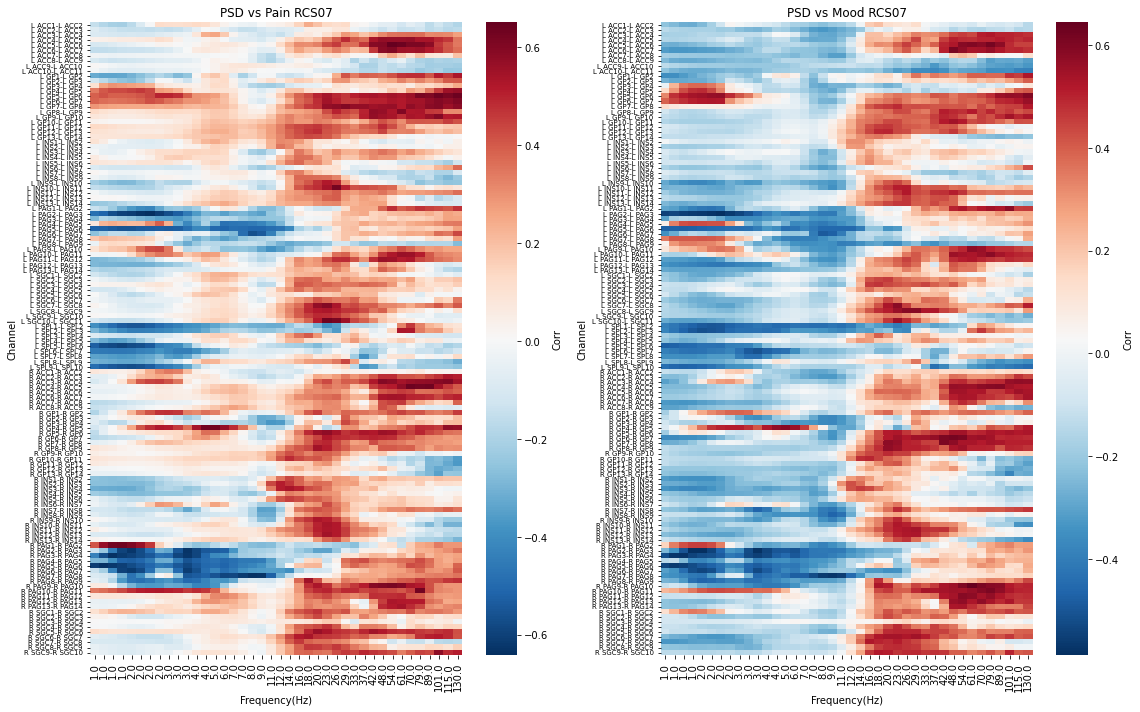

In [ ]:
sys.path.append("/home/aallawala/Plotting-GenFxns/")

def basic_heatmap(ax, array, cbar_title, title):
    fig_params = [8, 12]
    caxis_lim = [-0.1, 0.2]
    
    sns.heatmap((array.T), cmap="RdBu_r", cbar=True, 
                yticklabels=ch_labels, xticklabels=np.round(freqs), 
                cbar_kws={'label': cbar_title}, ax=ax)
    ax.set_xlabel("Frequency(Hz)")
    ax.set_ylabel("Channel")
    ax.set_title(title)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)


def plot_heatmap_subplots(data_list, cbar_titles, titles, nrows, ncols):
    """
    Generate subplots using the custom heatmap function.

    Parameters:
    data_list (list of ndarray): List of 2D arrays to be plotted as heatmaps.
    cbar_titles (list of str): List of colorbar titles for each heatmap.
    titles (list of str): List of titles for each heatmap.
    nrows (int): Number of rows in the subplot grid.
    ncols (int): Number of columns in the subplot grid.
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 10 * nrows))
    axes = axes.flatten() 

    for i, (array, cbar_title, title) in enumerate(zip(data_list, cbar_titles, titles)):
        basic_heatmap(axes[i], array, cbar_title, title)

    plt.tight_layout()
    save_dir = '/userdata/aallawala/pain_data/figures/071024_mood_partialcorr/%s_corr_mood_pain.png' % (ptID)

    plt.savefig(save_dir, dpi=300, edgecolor='k', facecolor="white")
    plt.show()


# Plot the heatmaps in a 2x2 grid
plot_heatmap_subplots([corr_vasp, corr_vasd], ['Corr', 'Corr'], ['PSD vs Pain %s' % (ptID), 'PSD vs Mood %s' % (ptID)], nrows=1, ncols=2)



In [348]:
mask_pvalues = pval_reshape > 0.05
# Apply mask: Set values where mask is True to NaN
masked_t_vals = np.where(mask_pvalues, np.nan, tval_reshape)

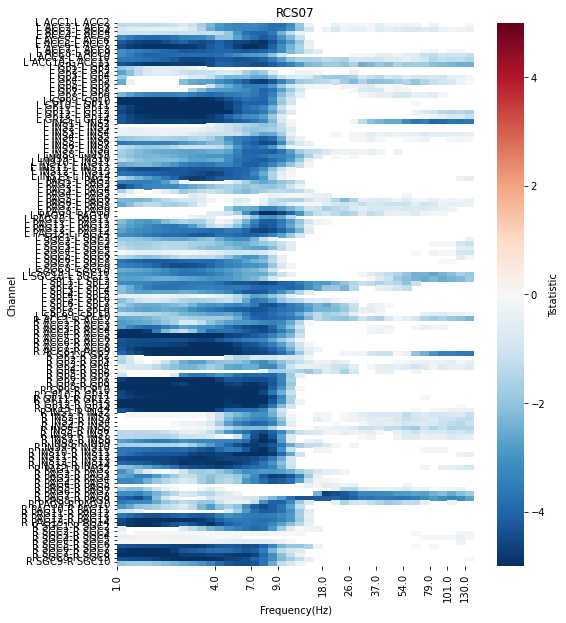

In [358]:

fig, ax = plt.subplots(figsize=[8,10])
sns.heatmap((masked_t_vals.T), cmap='RdBu_r', cbar=True, 
 vmin = -5, vmax = 5, yticklabels=ch_labels, xticklabels=np.round(freqs), cbar_kws={'label': 'Tstatistic'})

ytick_labels = ch_labels
if ptID=="RCS05":
    y_ticks = [0,8,21,32, 40, 50, 58, 71, 84, 91]
elif ptID=="RCS04":
    y_ticks = [0,8,15,26,31,41,47,54,65, 66]
elif ptID == "RCS02":
    y_ticks = [0,9,24, 40, 55,70,79,91,99]
elif ptID == "RCS07":
    y_ticks = [0,10,23,37,49,60,67,76,83,94,100,107]

y_ticks = np.arange(0,124,1)
ytick_labels = ch_labels
# x_ticks = [0, 11, 15, 18, 23, 26, 29, 32, 35, 37, 39]
xtick_labels = freqs[x_ticks]  # Use the correct subset of ylabels
ax.set(xticks = x_ticks, xticklabels = np.round(xtick_labels), yticks = y_ticks, yticklabels = ytick_labels)
plt.title(f"{ptID}")
ax.set_xlabel("Frequency(Hz)")
ax.set_ylabel("Channel")

savepath = f"/userdata/aallawala/pain_data/figures/mult_lin_reg/{ptID}_intercept_linearreg.png"
plt.savefig(savepath, dpi = 300, edgecolor = 'k', facecolor="white")
plt.show()



In [ ]:
from scipy import stats, linalg

# Step 1: Fit regression models and obtain residuals
# Regression of Y on Z

slope_YZ, intercept_YZ, _, _, _ = stats.linregress(Z, Y)
Y_pred = slope_YZ * Z + intercept_YZ
Y_resid = Y - Y_pred

# Regression of each feature in X on Z
X_resid = np.zeros_like(X)
for i in range(n_feats):
    slope_XZ, intercept_XZ, _, _, _ = stats.linregress(Z, X[:, i])
    X_pred = slope_XZ * Z + intercept_XZ
    X_resid[:, i] = X[:, i] - X_pred

# Step 2: Compute partial correlation coefficients
partial_corr_XY_Z_reg = np.zeros(n_feats)
for i in range(n_feats):
    partial_corr_XY_Z_reg[i], _ = stats.pearsonr(X_resid[:, i], Y_resid)

print("Partial correlation coefficients between X and Y controlling for Z using regression:")
pcorr_reshaped = partial_corr_XY_Z_reg.reshape(n_freq, n_ch)

Partial correlation coefficients between X and Y controlling for Z using regression:


get it


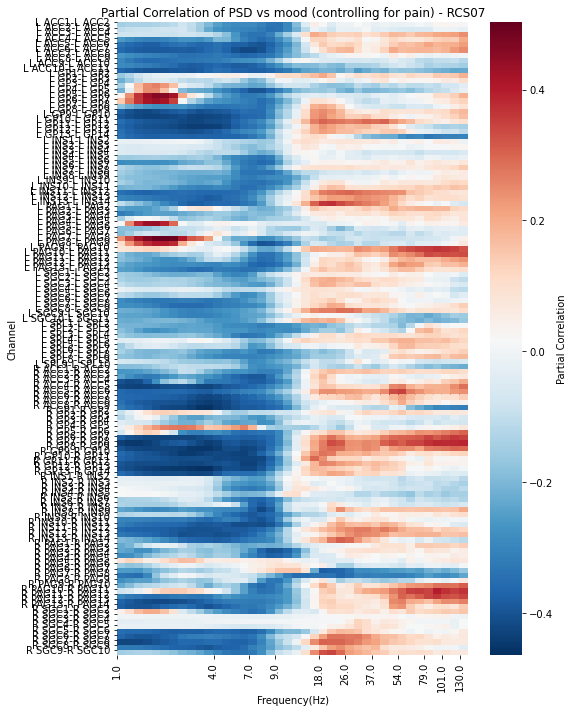

In [360]:
save_dir = '/userdata/aallawala/pain_data/figures/mult_lin_reg/%s_Partial_corr_mood_masked.png' % (ptID)
fig, ax = plt.subplots(figsize=[8,10])
ax = sns.heatmap((pcorr_reshaped.T), cmap="RdBu_r", cbar=True, 
    yticklabels=ch_labels, xticklabels=np.round(freqs), cbar_kws={'label': 'Partial Correlation'})
yticklabels='auto'
plt.xlabel("Frequency(Hz)")
plt.ylabel("Channel")
plt.title('Partial Correlation of PSD vs mood (controlling for pain) - %s' % (ptID))
# xticklabels = 'auto'
ytick_labels = ch_labels
if ptID=="RCS05":
    y_ticks = [0,8,21,32, 40, 50, 58, 71, 84, 91]
elif ptID=="RCS04":
    y_ticks = [0,8,15,26,31,41,47,54,65, 66]
elif ptID == "RCS02":
    y_ticks = [0,9,24, 40, 55,70,79,91,99]
elif ptID == "RCS07":
    print('get it')

y_ticks = np.arange(0,124,1)
ytick_labels = ytick_labels[y_ticks]
x_ticks = [0, 11, 15, 18, 23, 26, 29, 32, 35, 37, 39]
xtick_labels = freqs[x_ticks]  # Use the correct subset of ylabels
ax.set(xticks = x_ticks, xticklabels = np.round(xtick_labels), yticks = y_ticks, yticklabels = ytick_labels)
plt.tight_layout()
plt.savefig(save_dir, dpi=300, edgecolor='k', facecolor="white")

plt.show()
